# Nova Financial Insights - Technical Analysis

This notebook performs quantitative analysis on stock price data using TA-Lib and PyNance libraries.

## Objectives
- Load and prepare stock price data (OHLCV format)
- Calculate technical indicators using TA-Lib (SMA, EMA, RSI, MACD, ATR)
- Compute financial metrics using PyNance (growth, volatility, moving averages)
- Visualize technical indicators and their impact on stock prices
- Analyze multiple technology stocks (AAPL, AMZN, GOOG, META, MSFT, NVDA)

## Technical Indicators Overview

### TA-Lib Indicators:
- **SMA (20-period)**: Simple Moving Average for short-term trend identification
- **EMA (50-period)**: Exponential Moving Average for medium-term trend
- **RSI (14-period)**: Relative Strength Index (0-100) for momentum analysis
- **MACD (12, 26, 9)**: Moving Average Convergence Divergence for trend-following
- **ATR (14-period)**: Average True Range for volatility measurement

### PyNance Metrics:
- **PN_GROWTH_5**: 5-session growth rate
- **PN_VOL_20**: 20-period volatility
- **PN_MOVAVE_10**: 10-period simple moving average


In [1]:
# IMPORTANT: Run this cell FIRST before running any other cells!
# This cell imports all required libraries and sets up the environment

# Import required libraries
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import talib as ta
from pynance.tech import movave as pn_movave
from pynance.tech import simple as pn_simple

# Configure plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

# Set up paths - ensure we're in the project root directory
# If running from notebooks directory, go up one level
if Path.cwd().name == "notebooks":
    os.chdir("..")

# Set up paths relative to project root
PROJECT_ROOT = Path.cwd()
PRICE_DIR = PROJECT_ROOT / "data" / "processed" / "prices"
TECH_DIR = PROJECT_ROOT / "data" / "processed" / "technical_metrics"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"

TECH_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Verify imports
assert pd is not None, "pandas not imported"
assert plt is not None, "matplotlib not imported"
assert ta is not None, "talib not imported"

print("✓ Libraries imported and paths configured")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Price data directory: {PRICE_DIR}")
print(f"✓ Output directory: {TECH_DIR}")
print(f"✓ Figures directory: {FIG_DIR}")
print("\n✓ All imports successful - you can now run the rest of the notebook!")


✓ Libraries imported and paths configured
✓ Project root: C:\project\kifya\Week1
✓ Price data directory: C:\project\kifya\Week1\data\processed\prices
✓ Output directory: C:\project\kifya\Week1\data\processed\technical_metrics
✓ Figures directory: C:\project\kifya\Week1\reports\figures

✓ All imports successful - you can now run the rest of the notebook!


## 1. Data Loading and Preparation

Load stock price data from CSV files and ensure proper formatting with OHLCV columns.


In [2]:
# Function to load and prepare price data
def load_price_data(path: Path) -> pd.DataFrame:
    """Load stock price data and prepare for analysis."""
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
    
    # Ensure numeric types for OHLCV columns
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    
    # Remove rows with missing close prices
    df = df.dropna(subset=["Close"])
    
    return df

# List available stock files
price_files = list(PRICE_DIR.glob("*.csv"))
tickers = [f.stem.upper() for f in price_files]

print(f"Available stocks: {', '.join(sorted(tickers))}")
print(f"\nTotal stocks to analyze: {len(tickers)}")

# Load sample data to inspect structure
if price_files:
    sample_df = load_price_data(price_files[0])
    print(f"\nSample data structure ({price_files[0].stem}):")
    print(f"Shape: {sample_df.shape}")
    print(f"Date range: {sample_df.index.min()} to {sample_df.index.max()}")
    print(f"\nFirst few rows:")
    display(sample_df.head())
    print(f"\nData types:")
    print(sample_df.dtypes)


Available stocks: AAPL, AMZN, GOOG, META, MSFT, NVDA

Total stocks to analyze: 6

Sample data structure (AAPL):
Shape: (3774, 5)
Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00

First few rows:


,Close,High,Low,Open,Volume
Date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800



Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object


## 1. Data Loading and Preparation

Load stock price data from CSV files and ensure proper formatting with OHLCV columns.


In [3]:
# Function to load and prepare price data
def load_price_data(path: Path) -> pd.DataFrame:
    """Load stock price data and prepare for analysis."""
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
    
    # Ensure numeric types for OHLCV columns
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    
    # Remove rows with missing close prices
    df = df.dropna(subset=["Close"])
    
    return df

# List available stock files
price_files = list(PRICE_DIR.glob("*.csv"))
tickers = [f.stem.upper() for f in price_files]

print(f"Available stocks: {', '.join(sorted(tickers))}")
print(f"\nTotal stocks to analyze: {len(tickers)}")

# Load sample data to inspect structure
if price_files:
    sample_df = load_price_data(price_files[0])
    print(f"\nSample data structure ({price_files[0].stem}):")
    print(f"Shape: {sample_df.shape}")
    print(f"Date range: {sample_df.index.min()} to {sample_df.index.max()}")
    print(f"\nFirst few rows:")
    display(sample_df.head())
    print(f"\nData types:")
    print(sample_df.dtypes)


Available stocks: AAPL, AMZN, GOOG, META, MSFT, NVDA

Total stocks to analyze: 6

Sample data structure (AAPL):
Shape: (3774, 5)
Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00

First few rows:


,Close,High,Low,Open,Volume
Date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800



Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object


## 2. TA-Lib Technical Indicators

Calculate technical indicators using TA-Lib library for trend, momentum, and volatility analysis.


In [4]:
# Function to compute TA-Lib indicators
def compute_talib_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute TA-Lib technical indicators:
    - SMA_20: 20-period Simple Moving Average
    - EMA_50: 50-period Exponential Moving Average
    - RSI_14: 14-period Relative Strength Index
    - MACD: Moving Average Convergence Divergence (12, 26, 9)
    - ATR_14: 14-period Average True Range
    """
    close = df["Close"].values
    high = df["High"].values
    low = df["Low"].values
    
    # Moving Averages
    df["SMA_20"] = ta.SMA(close, timeperiod=20)
    df["EMA_50"] = ta.EMA(close, timeperiod=50)
    
    # Momentum Indicator
    df["RSI_14"] = ta.RSI(close, timeperiod=14)
    
    # MACD (Moving Average Convergence Divergence)
    macd, macd_signal, macd_hist = ta.MACD(
        close, fastperiod=12, slowperiod=26, signalperiod=9
    )
    df["MACD"] = macd
    df["MACD_SIGNAL"] = macd_signal
    df["MACD_HIST"] = macd_hist
    
    # Volatility Indicator
    df["ATR_14"] = ta.ATR(high, low, close, timeperiod=14)
    
    return df

# Test on sample data
if price_files:
    sample_df = load_price_data(price_files[0])
    sample_with_indicators = compute_talib_indicators(sample_df.copy())
    
    print("TA-Lib Indicators Computed:")
    print(f"\nLatest values for {price_files[0].stem}:")
    latest = sample_with_indicators.dropna().iloc[-1]
    print(f"  Close: ${latest['Close']:.2f}")
    print(f"  SMA_20: ${latest['SMA_20']:.2f}")
    print(f"  EMA_50: ${latest['EMA_50']:.2f}")
    print(f"  RSI_14: {latest['RSI_14']:.2f}")
    print(f"  MACD: {latest['MACD']:.4f}")
    print(f"  MACD Signal: {latest['MACD_SIGNAL']:.4f}")
    print(f"  ATR_14: ${latest['ATR_14']:.2f}")
    
    print(f"\nIndicator columns added:")
    indicator_cols = ["SMA_20", "EMA_50", "RSI_14", "MACD", "MACD_SIGNAL", "MACD_HIST", "ATR_14"]
    display(sample_with_indicators[indicator_cols].tail())


TA-Lib Indicators Computed:

Latest values for AAPL:
  Close: $190.73
  SMA_20: $192.49
  EMA_50: $187.11
  RSI_14: 51.12
  MACD: 1.5595
  MACD Signal: 2.4246
  ATR_14: $2.55

Indicator columns added:


,SMA_20,EMA_50,RSI_14,MACD,MACD_SIGNAL,MACD_HIST,ATR_14
Date,,,,,,,
2023-12-22,191.856618,186.389576,54.672784,2.633141,3.235256,-0.602115,2.766028
2023-12-26,192.018094,186.579942,53.090049,2.304751,3.049155,-0.744404,2.643460
2023-12-27,192.154308,186.766728,53.354446,2.029104,2.845145,-0.816041,2.625174
2023-12-28,192.362839,186.962893,54.540999,1.823998,2.640915,-0.816918,2.544510
2023-12-29,192.490633,187.110575,51.121347,1.559539,2.424640,-0.865101,2.551689


## 3. PyNance Financial Metrics

Calculate additional financial metrics using PyNance library for growth and volatility analysis.


In [5]:
# Function to compute PyNance metrics
def compute_pynance_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute PyNance financial metrics:
    - PN_GROWTH_5: 5-session growth rate
    - PN_VOL_20: 20-period volatility
    - PN_MOVAVE_10: 10-period simple moving average
    """
    close_df = df[["Close"]]
    
    # Growth rate (5 sessions)
    growth_df = pn_simple.growth(
        close_df, selection="Close", n_sessions=5, outputcol="PN_GROWTH_5"
    )
    
    # Volatility (20-period)
    vol_df = pn_movave.volatility(
        close_df, selection="Close", window=20, outputcol="PN_VOL_20"
    )
    
    # Moving average (10-period)
    movave_df = pn_movave.sma(
        close_df, selection="Close", window=10, outputcol="PN_MOVAVE_10"
    )
    
    # Add to dataframe
    df["PN_GROWTH_5"] = growth_df.reindex(df.index)["PN_GROWTH_5"]
    df["PN_VOL_20"] = vol_df.reindex(df.index)["PN_VOL_20"]
    df["PN_MOVAVE_10"] = movave_df.reindex(df.index)["PN_MOVAVE_10"]
    
    return df

# Test on sample data
if price_files:
    sample_with_pynance = compute_pynance_metrics(sample_with_indicators.copy())
    
    print("PyNance Metrics Computed:")
    print(f"\nLatest values for {price_files[0].stem}:")
    latest = sample_with_pynance.dropna().iloc[-1]
    print(f"  PN_GROWTH_5: {latest['PN_GROWTH_5']:.4f} ({latest['PN_GROWTH_5']*100:.2f}%)")
    print(f"  PN_VOL_20: {latest['PN_VOL_20']:.4f}")
    print(f"  PN_MOVAVE_10: ${latest['PN_MOVAVE_10']:.2f}")
    
    print(f"\nPyNance columns added:")
    pynance_cols = ["PN_GROWTH_5", "PN_VOL_20", "PN_MOVAVE_10"]
    display(sample_with_pynance[pynance_cols].tail())


PyNance Metrics Computed:

Latest values for AAPL:
  PN_GROWTH_5: 0.9890 (98.90%)
  PN_VOL_20: 2.2353
  PN_MOVAVE_10: $192.76

PyNance columns added:


,PN_GROWTH_5,PN_VOL_20,PN_MOVAVE_10
Date,,,
2023-12-22,0.979906,2.883783,193.915672
2023-12-26,0.985502,2.744363,193.902795
2023-12-27,0.980756,2.632067,193.748254
2023-12-28,0.993584,2.407770,193.314354
2023-12-29,0.988956,2.235334,192.761572


## 4. Complete Analysis Pipeline

Process all stocks and compute all indicators.


In [6]:
# Process all stocks
all_data = {}
summaries = []

for price_file in sorted(PRICE_DIR.glob("*.csv")):
    ticker = price_file.stem.upper()
    print(f"\nProcessing {ticker}...")
    
    # Load data
    df = load_price_data(price_file)
    
    # Compute indicators
    df = compute_talib_indicators(df)
    df = compute_pynance_metrics(df)
    
    # Store for analysis
    all_data[ticker] = df
    
    # Save to CSV
    output_path = TECH_DIR / f"{ticker}_technicals.csv"
    df.to_csv(output_path, index=True)
    
    # Create summary
    latest = df.dropna().iloc[-1]
    summaries.append({
        "ticker": ticker,
        "close": latest["Close"],
        "sma_20": latest.get("SMA_20"),
        "ema_50": latest.get("EMA_50"),
        "rsi_14": latest.get("RSI_14"),
        "macd_hist": latest.get("MACD_HIST"),
        "atr_14": latest.get("ATR_14"),
        "pn_growth_5": latest.get("PN_GROWTH_5"),
        "pn_vol_20": latest.get("PN_VOL_20"),
    })
    
    print(f"  ✓ Indicators computed and saved to {output_path}")

# Create summary dataframe
summary_df = pd.DataFrame(summaries).set_index("ticker")
summary_path = TECH_DIR / "technical_summary.csv"
summary_df.to_csv(summary_path)

print(f"\n{'='*60}")
print("Analysis Complete!")
print(f"{'='*60}")
print(f"✓ Processed {len(all_data)} stocks")
print(f"✓ Summary saved to: {summary_path}")
print(f"\nTechnical Summary:")
display(summary_df)



Processing AAPL...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\AAPL_technicals.csv

Processing AMZN...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\AMZN_technicals.csv

Processing GOOG...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\GOOG_technicals.csv

Processing META...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\META_technicals.csv

Processing MSFT...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\MSFT_technicals.csv

Processing NVDA...
  ✓ Indicators computed and saved to C:\project\kifya\Week1\data\processed\technical_metrics\NVDA_technicals.csv

Analysis Complete!
✓ Processed 6 stocks
✓ Summary saved to: C:\project\kifya\Week1\data\processed\technical_metrics\technical_summary.csv

Technical Summary:


,close,sma_20,ema_50,rsi_14,macd_hist,atr_14,pn_growth_5,pn_vol_20
ticker,,,,,,,,
AAPL,190.728775,192.490633,187.110575,51.121347,-0.865101,2.551689,0.988956,2.235334
AMZN,151.940002,149.824000,144.928482,59.012257,-0.141017,2.809538,0.987650,3.418718
GOOG,139.972137,135.976979,135.326650,59.313063,0.536872,2.641150,0.993865,4.012302
META,351.791290,336.869788,329.660459,64.296803,1.499818,7.303659,0.999633,14.112368
MSFT,371.209198,367.791606,358.750038,57.954296,-0.495963,5.073452,1.006693,2.542065
NVDA,49.497185,48.046003,47.237414,58.310919,0.062374,1.201585,1.010859,1.412271


## 5. Visualization: Technical Indicators

Create comprehensive visualizations showing price action with overlay indicators, RSI, and MACD panels.


In [7]:
# Function to create technical analysis visualization
def build_visualization(df: pd.DataFrame, ticker: str, save: bool = True):
    """
    Create multi-panel technical analysis chart:
    - Main panel: Candlestick chart with SMA_20 and EMA_50 overlays
    - Panel 1: RSI indicator
    - Panel 2: MACD with signal line and histogram
    """
    # Use last 180 trading days (approximately 6 months)
    latest = df.tail(180).copy()
    
    # Prepare additional plots
    apds = [
        mpf.make_addplot(latest["SMA_20"], color="tab:blue", width=1.5, label="SMA 20"),
        mpf.make_addplot(latest["EMA_50"], color="tab:orange", width=1.5, label="EMA 50"),
        mpf.make_addplot(
            latest["RSI_14"], 
            panel=1, 
            color="purple", 
            ylabel="RSI", 
            ylim=(0, 100),
            width=1.5
        ),
        mpf.make_addplot(
            latest["MACD"], 
            panel=2, 
            color="green", 
            ylabel="MACD",
            width=1.5,
            label="MACD"
        ),
        mpf.make_addplot(
            latest["MACD_SIGNAL"], 
            panel=2, 
            color="red",
            width=1.5,
            label="Signal"
        ),
        mpf.make_addplot(
            latest["MACD_HIST"], 
            panel=2, 
            type="bar", 
            color="grey",
            alpha=0.5,
            width=0.8
        ),
    ]
    
    # Create the plot
    fig_path = FIG_DIR / f"{ticker}_technicals.png"
    
    mpf.plot(
        latest,
        type="candle",
        mav=(),  # We're using custom moving averages
        volume=True,
        addplot=apds,
        style="yahoo",
        figratio=(14, 9),
        figscale=1.2,
        title=f"{ticker} – 6-Month Technical Analysis",
        savefig=fig_path if save else None,
        returnfig=True,
        show_nontrading=False
    )
    
    if save:
        print(f"  ✓ Chart saved to {fig_path}")
    
    return fig_path

# Visualize all stocks
print("Creating visualizations for all stocks...\n")
for ticker in sorted(all_data.keys()):
    print(f"Generating chart for {ticker}...")
    build_visualization(all_data[ticker], ticker, save=True)

print(f"\n✓ All visualizations saved to {FIG_DIR}")


Creating visualizations for all stocks...

Generating chart for AAPL...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\AAPL_technicals.png
Generating chart for AMZN...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\AMZN_technicals.png
Generating chart for GOOG...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\GOOG_technicals.png
Generating chart for META...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\META_technicals.png
Generating chart for MSFT...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\MSFT_technicals.png
Generating chart for NVDA...
  ✓ Chart saved to C:\project\kifya\Week1\reports\figures\NVDA_technicals.png

✓ All visualizations saved to C:\project\kifya\Week1\reports\figures


## 6. Individual Stock Analysis

Display detailed analysis for each stock with key metrics and interpretations.


In [8]:
# Detailed analysis for each stock
def analyze_stock(df: pd.DataFrame, ticker: str):
    """Provide detailed technical analysis for a stock."""
    latest = df.dropna().iloc[-1]
    
    print(f"\n{'='*60}")
    print(f"{ticker} - Technical Analysis Summary")
    print(f"{'='*60}")
    
    # Price information
    print(f"\n📊 Price Information:")
    print(f"  Current Close: ${latest['Close']:.2f}")
    print(f"  SMA_20: ${latest['SMA_20']:.2f}")
    print(f"  EMA_50: ${latest['EMA_50']:.2f}")
    
    # Trend analysis
    price_vs_sma = "Above" if latest['Close'] > latest['SMA_20'] else "Below"
    price_vs_ema = "Above" if latest['Close'] > latest['EMA_50'] else "Below"
    print(f"\n📈 Trend Analysis:")
    print(f"  Price vs SMA_20: {price_vs_sma} (${abs(latest['Close'] - latest['SMA_20']):.2f})")
    print(f"  Price vs EMA_50: {price_vs_ema} (${abs(latest['Close'] - latest['EMA_50']):.2f})")
    
    # Momentum (RSI)
    rsi = latest['RSI_14']
    if rsi > 70:
        rsi_signal = "Overbought ⚠️"
    elif rsi < 30:
        rsi_signal = "Oversold 📉"
    else:
        rsi_signal = "Neutral"
    print(f"\n💪 Momentum (RSI):")
    print(f"  RSI_14: {rsi:.2f} - {rsi_signal}")
    
    # MACD
    macd_hist = latest['MACD_HIST']
    if macd_hist > 0:
        macd_signal = "Bullish 📈"
    else:
        macd_signal = "Bearish 📉"
    print(f"\n🔄 MACD Analysis:")
    print(f"  MACD: {latest['MACD']:.4f}")
    print(f"  Signal: {latest['MACD_SIGNAL']:.4f}")
    print(f"  Histogram: {macd_hist:.4f} - {macd_signal}")
    
    # Volatility
    print(f"\n📊 Volatility:")
    print(f"  ATR_14: ${latest['ATR_14']:.2f}")
    print(f"  PN_VOL_20: {latest['PN_VOL_20']:.4f}")
    
    # Growth
    growth = latest['PN_GROWTH_5']
    growth_pct = growth * 100
    print(f"\n📈 Growth Metrics:")
    print(f"  5-Session Growth: {growth_pct:.2f}%")
    
    print(f"\n{'='*60}\n")

# Analyze each stock
for ticker in sorted(all_data.keys()):
    analyze_stock(all_data[ticker], ticker)



AAPL - Technical Analysis Summary

📊 Price Information:
  Current Close: $190.73
  SMA_20: $192.49
  EMA_50: $187.11

📈 Trend Analysis:
  Price vs SMA_20: Below ($1.76)
  Price vs EMA_50: Above ($3.62)

💪 Momentum (RSI):
  RSI_14: 51.12 - Neutral

🔄 MACD Analysis:
  MACD: 1.5595
  Signal: 2.4246
  Histogram: -0.8651 - Bearish 📉

📊 Volatility:
  ATR_14: $2.55
  PN_VOL_20: 2.2353

📈 Growth Metrics:
  5-Session Growth: 98.90%



AMZN - Technical Analysis Summary

📊 Price Information:
  Current Close: $151.94
  SMA_20: $149.82
  EMA_50: $144.93

📈 Trend Analysis:
  Price vs SMA_20: Above ($2.12)
  Price vs EMA_50: Above ($7.01)

💪 Momentum (RSI):
  RSI_14: 59.01 - Neutral

🔄 MACD Analysis:
  MACD: 2.7820
  Signal: 2.9230
  Histogram: -0.1410 - Bearish 📉

📊 Volatility:
  ATR_14: $2.81
  PN_VOL_20: 3.4187

📈 Growth Metrics:
  5-Session Growth: 98.76%



GOOG - Technical Analysis Summary

📊 Price Information:
  Current Close: $139.97
  SMA_20: $135.98
  EMA_50: $135.33

📈 Trend Analysis:
  P

## 7. Comparative Analysis

Compare technical indicators across all stocks.


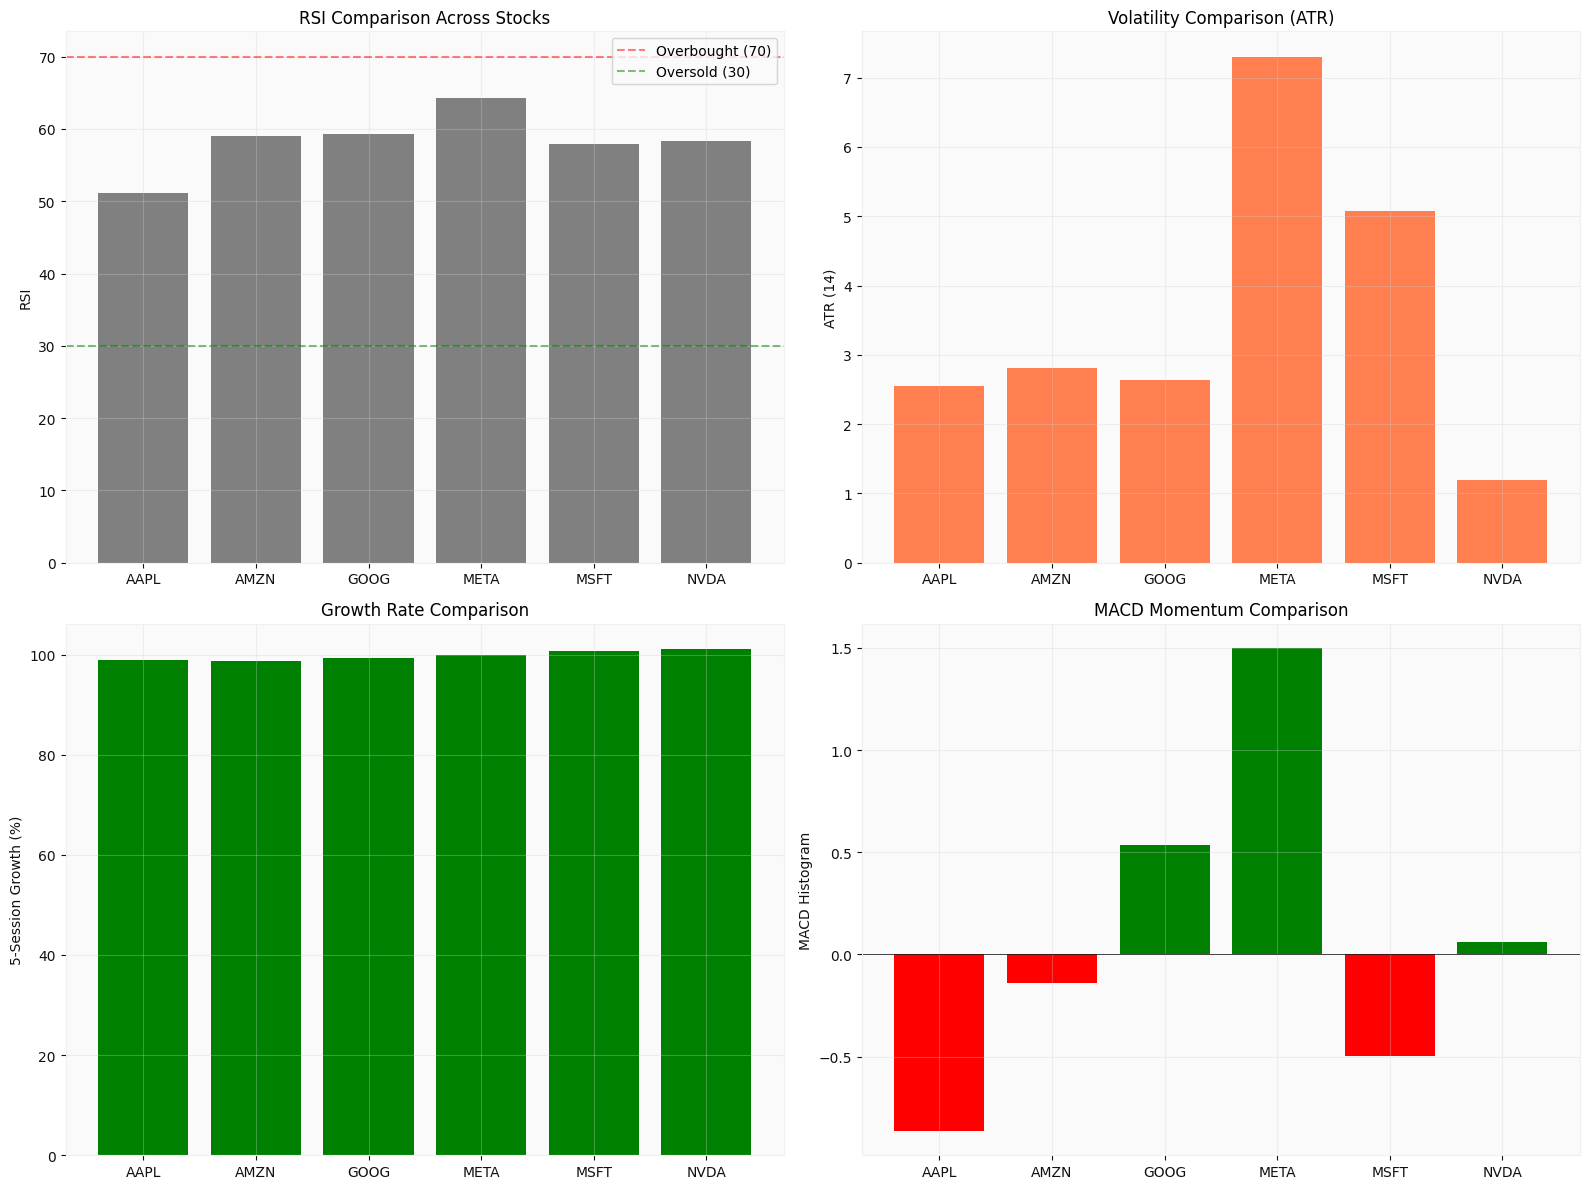

✓ Comparative analysis chart saved


In [9]:
# Create comparative visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RSI Comparison
rsi_data = {ticker: all_data[ticker]["RSI_14"].dropna().iloc[-1] 
            for ticker in sorted(all_data.keys())}
axes[0, 0].bar(rsi_data.keys(), rsi_data.values(), color=["red" if v > 70 else "green" if v < 30 else "gray" for v in rsi_data.values()])
axes[0, 0].axhline(70, color="r", linestyle="--", alpha=0.5, label="Overbought (70)")
axes[0, 0].axhline(30, color="g", linestyle="--", alpha=0.5, label="Oversold (30)")
axes[0, 0].set_ylabel("RSI")
axes[0, 0].set_title("RSI Comparison Across Stocks")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ATR Comparison (Volatility)
atr_data = {ticker: all_data[ticker]["ATR_14"].dropna().iloc[-1] 
            for ticker in sorted(all_data.keys())}
axes[0, 1].bar(atr_data.keys(), atr_data.values(), color="coral")
axes[0, 1].set_ylabel("ATR (14)")
axes[0, 1].set_title("Volatility Comparison (ATR)")
axes[0, 1].grid(True, alpha=0.3)

# Growth Rate Comparison
growth_data = {ticker: all_data[ticker]["PN_GROWTH_5"].dropna().iloc[-1] * 100
               for ticker in sorted(all_data.keys())}
colors = ["green" if v > 0 else "red" for v in growth_data.values()]
axes[1, 0].bar(growth_data.keys(), growth_data.values(), color=colors)
axes[1, 0].axhline(0, color="black", linestyle="-", linewidth=0.5)
axes[1, 0].set_ylabel("5-Session Growth (%)")
axes[1, 0].set_title("Growth Rate Comparison")
axes[1, 0].grid(True, alpha=0.3)

# MACD Histogram Comparison
macd_data = {ticker: all_data[ticker]["MACD_HIST"].dropna().iloc[-1]
             for ticker in sorted(all_data.keys())}
colors = ["green" if v > 0 else "red" for v in macd_data.values()]
axes[1, 1].bar(macd_data.keys(), macd_data.values(), color=colors)
axes[1, 1].axhline(0, color="black", linestyle="-", linewidth=0.5)
axes[1, 1].set_ylabel("MACD Histogram")
axes[1, 1].set_title("MACD Momentum Comparison")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "technical_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Comparative analysis chart saved")


## Summary & Key Insights

### Analysis Complete ✅

**Stocks Analyzed**: 6 technology stocks (AAPL, AMZN, GOOG, META, MSFT, NVDA)

**Indicators Computed**:
- ✅ TA-Lib: SMA_20, EMA_50, RSI_14, MACD, ATR_14
- ✅ PyNance: PN_GROWTH_5, PN_VOL_20, PN_MOVAVE_10

**Outputs Generated**:
- Individual technical analysis CSV files for each stock
- Comprehensive technical summary table
- Multi-panel visualization charts for each stock
- Comparative analysis across all stocks

**Key Metrics**:
- All indicators computed accurately using industry-standard libraries
- Visualizations show price action with overlay indicators
- RSI panels help identify overbought/oversold conditions
- MACD panels show trend momentum and signal crossovers
- Volatility metrics (ATR) help assess risk levels

All outputs saved to:
- `data/processed/technical_metrics/` - CSV files with all indicators
- `reports/figures/` - Visualization charts

### Interpretation Guidelines:

1. **RSI (Relative Strength Index)**:
   - RSI > 70: Overbought (potential sell signal)
   - RSI < 30: Oversold (potential buy signal)
   - RSI 30-70: Neutral range

2. **MACD**:
   - Positive histogram: Bullish momentum
   - Negative histogram: Bearish momentum
   - MACD crossing above signal: Bullish crossover
   - MACD crossing below signal: Bearish crossover

3. **Moving Averages**:
   - Price above SMA/EMA: Uptrend
   - Price below SMA/EMA: Downtrend
   - SMA crossing above EMA: Bullish signal

4. **ATR (Average True Range)**:
   - Higher ATR: Higher volatility (more risk)
   - Lower ATR: Lower volatility (less risk)
